Dataclasses & Pydantic Models
=============================

Dataclasses and Pydantic models can easily be registered with their GUI.


Dataclasses
-----------

### Example: automatically create a GUI for a "Person" dataclass

To create a GUI for a dataclass, you first need to register the dataclass with its GUI.

For this, you can use `fl.register_dataclass(dataclass_type, **fiat_attributes)` or the `@fl.dataclass_with_gui_registration(**fiat_attributes)` decorator.

In either case, you can specify GUI options for the fields using the [fiat_attributes]((manual_fiat_attributes)) mechanism.

**Option 1: using `register_dataclass`:**

In [1]:
import fiatlight as fl
from dataclasses import dataclass

class Person:
    name: str
    age: int

fl.register_dataclass(Person, age__range=(0, 120))

**Option 2: using the decorator `dataclass_with_gui_registration`:**

In [2]:
import fiatlight as fl
from dataclasses import dataclass

@fl.dataclass_with_gui_registration(age__range=(0, 120))
class Person:
    name: str
    age: int

(This option is shorter, but more intrusive, as it modifies the original class definition.)

### Use the generated GUI in Fiatlight

You can use the dataclass as a function parameter, and fiatlight will generate a GUI for it.

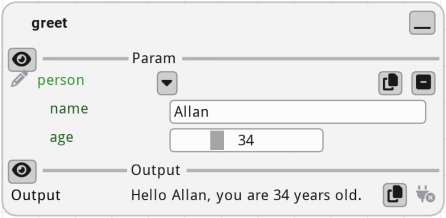

In [4]:
def greet(person: Person) -> str:
    return f"Hello {person.name}, you are {person.age} years old."

# Note: this app *will not* remember the values of the dataclass fields between runs
fl.run(greet, app_name="Dataclass Person")

### Or use the generate GUI in standalone application

Alternatively, you can use the generated GUI in a standalone application. Below we run an application using hello_imgui.
For more info, see [Dear ImGui Bundle doc](https://pthom.github.io/imgui_bundle/).

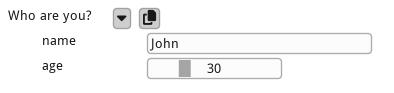

In [6]:
from imgui_bundle import hello_imgui

PERSON = Person(name="John", age=30)

def gui():
    global PERSON
    _changed, PERSON = fl.immediate_edit("Who are you?", PERSON)

hello_imgui.run(gui)

Pydantic models
---------------

Below is a more complete example of how to use Pydantic models with fiatlight.

### Example: automatically create a GUI for nested Pydantic models

**Notes:**
* fiatlight will automatically generate a serialization/deserialization mechanism for Pydantic models, so that user entries can be saved and reloaded (when used as function parameters). This is not available for dataclasses.

* Pydantic models can be nested: in the example below, you will see 3 levels of nesting, and fiatlight will generate a nice GUI for those.

* You can use `fl.register_base_model` to register a Pydantic model with its GUI and add fiat attributes Alternatively, you can use the `@fl.base_model_with_gui_registration` decorator (but this is more intrusive, as it modifies the original class definition).

* You can specify GUI options for the fields using the [fiat_attributes]((manual_fiat_attributes)) mechanism.

* Pydantic field validators (such as `Field(ge=0, le=90, ...)`) are supported and will be reflected in the GUI.

* Custom validators can be used, as shown in the example below.

* Validation errors will be displayed in the GUI (in yellow)

In [5]:
import fiatlight as fl
from enum import Enum
from pydantic import BaseModel, Field


# An Enum which will be associated to a Gui automatically
class TrainingDataType(Enum):
    Test = "test"
    Train = "train"
    Validation = "validation"


# GeographicInfo: a pydantic model, with validation on latitude and longitude
# which will be reflected in the GUI
class GeographicInfo(BaseModel):
    latitude: float = Field(ge=0, le=90, default=0)
    longitude: float = Field(ge=-180, lt=180, default=0)

# We register the GeographicInfo model with its GUI
# (the sliders for lon/lat will be limited to the ranges specified in the Fields)
fl.register_base_model(GeographicInfo)


# A custom validator, which will be used to validate the short description
def validate_short_description(value: str) -> str:
    if len(value) > 30:
        raise ValueError("Description is too long")
    return value


# A second model, which nests the first one (GeographicInfo)
class ImageInfo(BaseModel):
    geo_info: GeographicInfo = GeographicInfo()
    description: str = "Short Description..."
    width: int = 0
    height: int = 0

# We register the ImageInfo model with its GUI, and add some fiat attributes
# Also, we add a custom Fiatlight validator for the description field
fl.register_base_model(
    ImageInfo,
    width__range=(0, 2000),
    height__range=(0, 2000),
    description__label="Description",
    description__validator=validate_short_description,
    geo_info__label="Geographic Info",
)



# A third model, which nests the second one (ImageInfo)
# In total, it has 3 levels: TrainingImage -> ImageInfo -> GeographicInfo
# In this case, we use the decorator to register the model with its GUI
@fl.base_model_with_gui_registration(
    image_path__label="Select Image",
    training_type__label="Training Set",
    info__label="Image Info",
)
class TrainingImage(BaseModel):
    image_path: fl.fiat_types.ImagePath = ""  # type: ignore
    training_type: TrainingDataType = TrainingDataType.Test
    info: ImageInfo = ImageInfo(width=0, height=0)

### Use the generated GUI in a standalone application

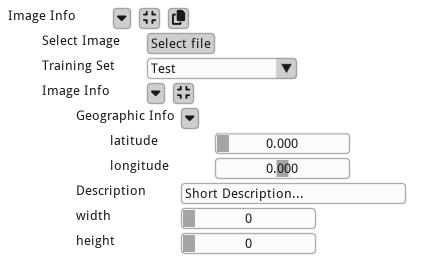

In [6]:
from imgui_bundle import hello_imgui

# We create an instance of the Pydantic model
IMAGE = TrainingImage()

def gui():
    global IMAGE
    _changed, IMAGE = fl.immediate_edit("Image Info", IMAGE)

hello_imgui.run(gui)

### Or use the generated GUI in Fiatlight

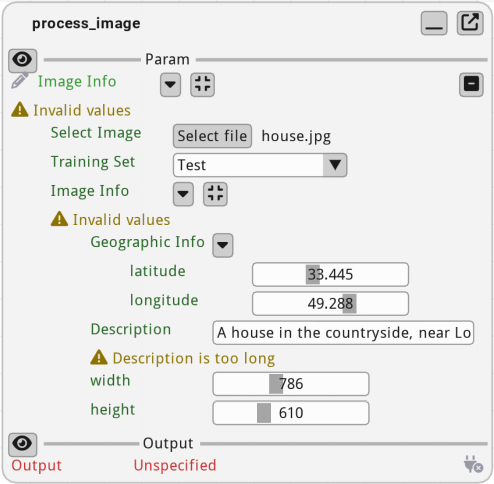

In [8]:
def process_image(image: TrainingImage) -> str:
    import os
    basename = os.path.basename(image.image_path)
    return basename

# Note: this app *will* remember the values of the Pydantic model fields between runs
fl.run(process_image, app_name="Pydantic Image Model")

In the previous screenshot, the GUI generated by `fl.base_model_with_gui_registration`
will automatically validate the data according to the model's constraints, and thus display an error message (because in this case, the description is too long).



Video Tutorial
==============
A short video tutorial is available for this topic.

🔗 [Watch Video](https://share.descript.com/view/CxaFQ5T6iq7)